In [16]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import matplotlib.pyplot as plt
import math
import SALib
from scipy.optimize import fsolve
from scipy.constants import N_A

In [17]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*100000000
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [18]:
(1e6*(tumour_cell_surface_area**2)*3/(N_A*4*1e-15*2*math.pi))**(1/3)

5.042393367698325e-08

In [19]:
rtot = 1e2
(np.sqrt((4*math.pi*((tumour_cell_radius)**2))/rtot))

2.8359261614488256e-06

In [20]:
def model_R_monospecific(t, z, Ainit, kon, koff, r_ab, rtot):
    k = Ainit*kon
    Atot = well_size*N_A*Ainit/Target_cell_number
    reaction_volume = (2*math.pi*(r_ab**3))/3
    A0 = Atot - z[0] - z[1] 
    Ag = rtot - z[0] - 2*z[1]
    target_effective_conc1 =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
    k2 = target_effective_conc1*kon
    dA10 = 2*(k*Ag*A0/(Atot)) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
    dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

    return [dA10, dA11]

In [21]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot, dummy):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'r_ab', 'koff', 'dummy'],
    'bounds': [[1e3, 1e7],
               [1e4, 1e6],
               [2e-11, 2e-7],
               [1e-6, 1e-1],
               [1, 1000]]
}

In [22]:
vals = SALib.sample.sobol.sample(problem1, 131072)
Y_ag1 = np.zeros(len(vals))
Y_ag2 = np.zeros(len(vals))
Y_ab = np.zeros(len(vals))
indicies_ag1 = []
indicies_ag2 = []
indicies_ab = []
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

Y = np.zeros(len(vals))
indicies = []
indicies_1 = []

In [23]:
16384*16

262144

In [24]:
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
      
        rtot = params[0]
        kon = params[1]
        r_ab = params[2]
        koff = params[3]
        dummy = params[4]

        reaction_volume = (2/3)*math.pi*((r_ab)**3)
        target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
        k2 = target_effective_conc*kon/rtot

        if Ainit < 1e-8:
            guess = 0
        else:
            guess = 0

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot, dummy)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag = (A1_st + A2_st)
        Y[i] = Ag
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])


1e-11


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.332822  0.002964
kon    0.299594  0.003398
r_ab   0.378262  0.003965
koff   0.242675  0.002997
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.232157  0.005131
kon    0.203486  0.004524
r_ab   0.243716  0.004157
koff   0.145078  0.003584
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.008192  0.005850
(rtot, r_ab)   0.026523  0.006083
(rtot, koff)   0.012355  0.005946
(rtot, dummy)  0.000041  0.005566
(kon, r_ab)    0.024692  0.006466
(kon, koff)    0.011562  0.006041
(kon, dummy)   0.000246  0.006120
(r_ab, koff)   0.028881  0.005192
(r_ab, dummy)  0.000309  0.004930
(koff, dummy) -0.000161  0.004085
1e-10
             ST   ST_conf
rtot   0.339004  0.003647
kon    0.296090  0.002920
r_ab   0.373183  0.003883
koff   0.239363  0.002453
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.240123  0.005029
kon    0.201422  0.004238
r_ab   0.241457  0.004468
koff   0.143928  0.003379
dummy  0.000000  0.000

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.395772  0.004072
kon    0.266845  0.002966
r_ab   0.331087  0.003448
koff   0.213332  0.002796
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.310071  0.005561
kon    0.183894  0.004204
r_ab   0.221172  0.004102
koff   0.133453  0.003615
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.012773  0.006268
(rtot, r_ab)   0.023554  0.006174
(rtot, koff)   0.011929  0.006561
(rtot, dummy)  0.000271  0.006293
(kon, r_ab)    0.021259  0.006269
(kon, koff)    0.009843  0.006087
(kon, dummy)   0.000048  0.005509
(r_ab, koff)   0.025498  0.004919
(r_ab, dummy) -0.000042  0.004493
(koff, dummy) -0.000392  0.004684
1e-08


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.688265  0.005064
kon    0.155676  0.002059
r_ab   0.164166  0.002295
koff   0.121060  0.001931
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.601306  0.005714
kon    0.104536  0.003674
r_ab   0.099957  0.002961
koff   0.077100  0.002531
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.028562  0.007276
(rtot, r_ab)   0.031780  0.007075
(rtot, koff)   0.018192  0.007123
(rtot, dummy) -0.000108  0.006739
(kon, r_ab)    0.009764  0.004494
(kon, koff)    0.004494  0.004371
(kon, dummy)  -0.000097  0.004394
(r_ab, koff)   0.012857  0.004280
(r_ab, dummy) -0.000096  0.004231
(koff, dummy) -0.000082  0.003305
1e-07


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.894757  0.005492
kon    0.100317  0.002254
r_ab   0.029603  0.000586
koff   0.039085  0.000980
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.868727  0.006362
kon    0.057669  0.002747
r_ab   0.002631  0.001346
koff   0.017292  0.001524
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.014263  0.007581
(rtot, r_ab)   0.000331  0.007025
(rtot, koff)   0.003636  0.007392
(rtot, dummy) -0.000006  0.006994
(kon, r_ab)    0.013358  0.003268
(kon, koff)    0.006834  0.003440
(kon, dummy)  -0.000108  0.003247
(r_ab, koff)   0.005772  0.002001
(r_ab, dummy)  0.000018  0.002068
(koff, dummy)  0.000032  0.002294
1e-06


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.906273  0.005901
kon    0.021807  0.000725
r_ab   0.101441  0.001009
koff   0.006517  0.000299
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.879841  0.006172
kon    0.011125  0.001057
r_ab   0.073941  0.002356
koff   0.001683  0.000572
dummy  0.000000  0.000000
                         S2   S2_conf
(rtot, kon)    2.632472e-03  0.008094
(rtot, r_ab)   2.156924e-02  0.008155
(rtot, koff)   3.999430e-04  0.008005
(rtot, dummy) -9.216669e-07  0.008007
(kon, r_ab)    3.355506e-03  0.001604
(kon, koff)    2.323543e-03  0.001494
(kon, dummy)  -1.709241e-05  0.001496
(r_ab, koff)   6.281676e-04  0.003502
(r_ab, dummy)  4.681431e-05  0.003512
(koff, dummy)  2.199668e-05  0.000867
1e-05


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.742253  0.005317
kon    0.665206  0.007424
r_ab   0.075987  0.001267
koff   0.002245  0.000513
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.280611  0.006990
kon    0.207188  0.005219
r_ab   0.044485  0.002003
koff   0.000049  0.000360
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.435496  0.009008
(rtot, r_ab)   0.009575  0.009125
(rtot, koff)  -0.000678  0.009074
(rtot, dummy) -0.000518  0.009034
(kon, r_ab)    0.005055  0.005846
(kon, koff)   -0.000732  0.005598
(kon, dummy)  -0.000870  0.005571
(r_ab, koff)  -0.000346  0.003147
(r_ab, dummy) -0.000321  0.003128
(koff, dummy) -0.000134  0.000576


In [25]:
16384*2*2

65536

In [26]:
(3*1e4*1e3*tumour_cell_surface_area/(2*1e4*N_A*math.pi))**(1/3)

8.607164580321545e-11

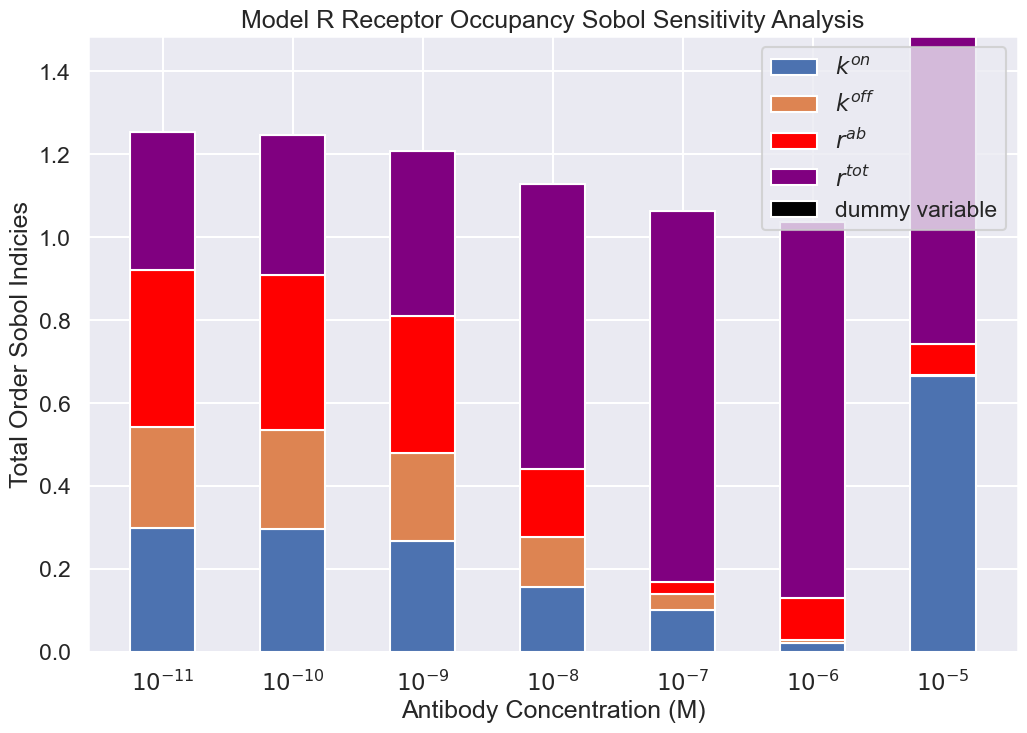

In [27]:
kon1_si = np.zeros(len(A0s))
koff1_si = np.zeros(len(A0s))
rtot1_si = np.zeros(len(A0s))
r_ab_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies)):
    vals = indicies[i]
    rtot1_si[i] = vals[0]
    kon1_si[i] = vals[1]
    r_ab_si[i] = vals[2]
    koff1_si[i] = vals[3]
    dummy_si[i] = vals[4]

ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon1_si,
    r"$k^{off}$": koff1_si,
}

sns.set_theme()
sns.set_context("talk")
width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie

ax.bar(ab_conc, r_ab_si, width, label=r'$r^{ab}$', bottom= bottom, color='red')
bottom+= r_ab_si
ax.bar(ab_conc, rtot1_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot1_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.set_title('Model R Receptor Occupancy Sobol Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('Total Order Sobol Indicies')
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_r_corrected_total_ab_number_total_order_sensiv_analysis.png')

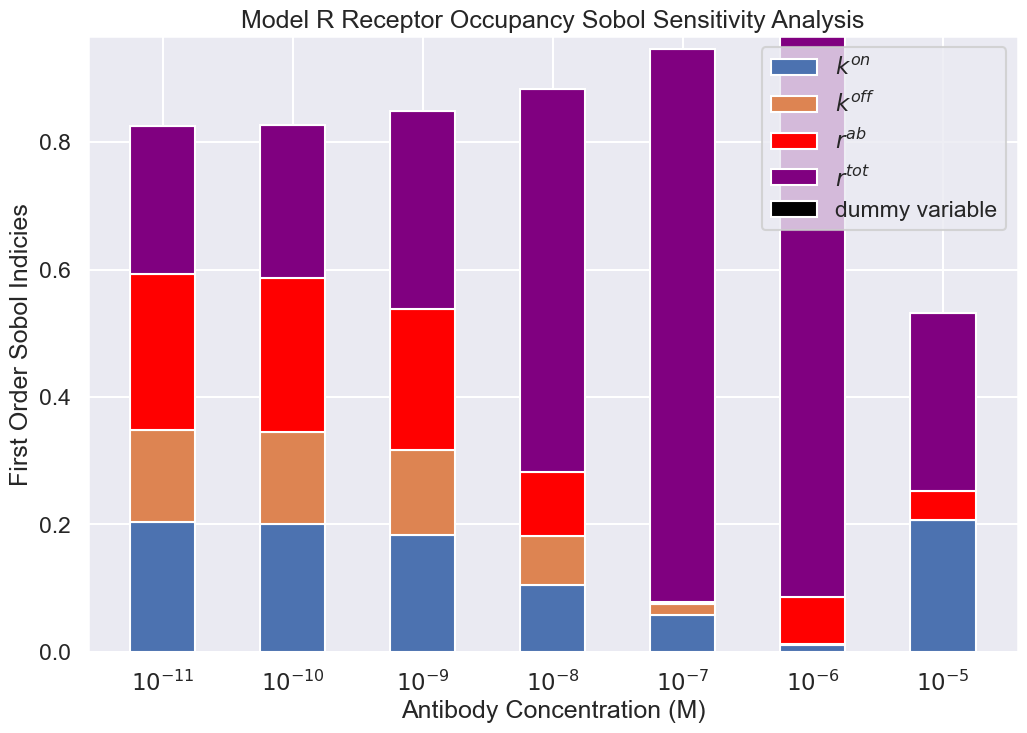

In [28]:
kon1_si = np.zeros(len(A0s))
koff1_si = np.zeros(len(A0s))
rtot1_si = np.zeros(len(A0s))
r_ab_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies_1)):
    vals = indicies_1[i]
    rtot1_si[i] = vals[0]
    kon1_si[i] = vals[1]
    r_ab_si[i] = vals[2]
    koff1_si[i] = vals[3]
    dummy_si[i] = vals[4]

ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon1_si,
    r"$k^{off}$": koff1_si,
}

sns.set_theme()
sns.set_context("talk")
width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie

ax.bar(ab_conc, r_ab_si, width, label=r'$r^{ab}$', bottom= bottom, color='red')
bottom+= r_ab_si
ax.bar(ab_conc, rtot1_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot1_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.set_title('Model R Receptor Occupancy Sobol Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('First Order Sobol Indicies')
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_r_corrected_total_ab_number_first_order_sensiv_analysis.png')